<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 36.8MB/s 
     |████████████████████████████████| 450kB 49.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6c12d94e97c99042be46cbc8a97fa1d9f4f0c582484190ba6740715c982f61d8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Un

In [2]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')
data.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,مظنه,2019-11-20,0.0,1000000.0,0.0,1000000.0,0
1,مظنه,2019-11-23,0.0,1000000.0,0.0,1000000.0,0
2,مظنه,2019-11-24,0.0,1000000.0,0.0,1000000.0,0
3,مظنه,2019-11-25,0.0,1000000.0,0.0,1000000.0,0
4,مظنه,2019-11-26,0.0,1000000.0,0.0,1000000.0,0


In [4]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


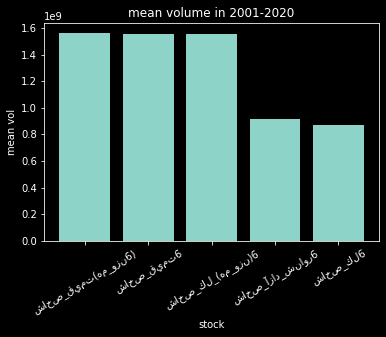

In [5]:
 plt.style.use('dark_background')
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [6]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),2015-02-24,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),2015-02-25,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),2015-02-28,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),2015-03-01,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),2015-03-02,9034.4,9043.5,9034.4,9043.5,717632564


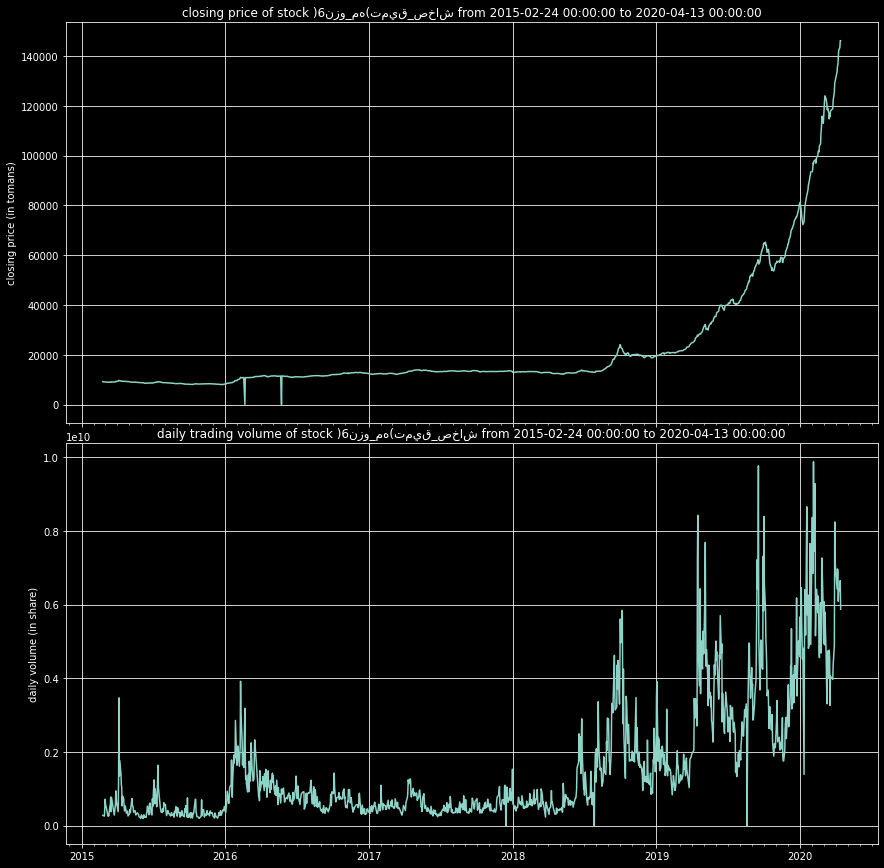

In [7]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,12))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)


ax1.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)
ax2.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)

ax1.grid(True)
ax2.grid(True)

ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.format_ydata = lambda x: '$%1.2f' % x  # format the price.

plt.show()

In [8]:
ten_stocks_with_max_trading_per_day = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_per_day = ten_stocks_with_max_trading_per_day['TICKER'].iloc[0]
ten_stocks_with_max_trading_per_day.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

In [0]:

window_in_days = 10
horizon_in_days = 1

def push_padding_to_dataframe_to_front(dataframe, window_in_days):
  for _ in range(window_in_days):
    row_to_insert = [0.0 for _ in dataframe.columns]
    dataframe.loc[-1] = row_to_insert
    dataframe.index = dataframe.index + 1
    dataframe = dataframe.sort_index()
    dataframe = dataframe.reset_index(drop=True)
  return dataframe


def normalize_dataframe(dataframe, train_mean, train_std):
    normalized_df=(dataframe-train_mean)/train_std
    return normalized_df


def generate_datasets_for_model(original_dataset, stock, training_start, training_end, testing_start, testing_end, window_in_days=10, batch_size=32):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ]
  data_related_to_stock = data_related_to_stock.drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) & (data_related_to_stock['DATE'] <= training_end )
  testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) & (data_related_to_stock['DATE'] <= testing_end )

  training_period = data_related_to_stock.loc[training_period_mask]
  testing_period = data_related_to_stock.loc[testing_period_mask]


  # training_period, validation_period = numpy.split(training_period, [int(.8*len(training_period))])


  training_period.drop('DATE', axis=1)
  testing_period.drop('DATE', axis=1)

  #training_period = push_padding_to_dataframe_to_front(training_period.copy(), (batch_size - (len(training_period) - window_in_days) ) % batch_size)
  # validation_period = push_padding_to_dataframe_to_front(validation_period.copy(), window_in_days) 
  #testing_period = push_padding_to_dataframe_to_front(testing_period.copy(), window_in_days)




  training_period_labels = numpy.where(training_period['CLOSE'] > training_period['CLOSE'].shift(1), 1.0, 0.0)
  # validation_period_labels = numpy.where(validation_period['CLOSE'] > validation_period['CLOSE'].shift(1), 1.0, 0.0) 
  testing_period_labels = numpy.where(testing_period['CLOSE'] > testing_period['CLOSE'].shift(1), 1.0, 0.0)

  training_period = training_period.drop('DATE', axis=1)
  # validation_period = validation_period.drop('DATE', axis=1)
  testing_period = testing_period.drop('DATE', axis=1)

  training_period = normalize_dataframe(training_period, training_period.mean(), training_period.std())
  # validation_period = normalize_dataframe(validation_period, training_period.mean(), training_period.std())
  testing_period = normalize_dataframe(testing_period, training_period.mean(), training_period.std())

  training_data = []
  training_labels = []

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(training_period_labels[j])

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  # validation_data = []
  # validation_labels = []

  
  # for j in range(window_in_days, len(validation_period)):
  #   validation_data.append(numpy.array(validation_period[ j - window_in_days : j ].copy()))
  #   validation_labels.append(validation_period_labels[j])

  # validation_data = numpy.array(validation_data)
  # validation_labels = numpy.array(validation_labels)


  testing_data = []
  testing_labels = []


  for j in range(window_in_days, len(testing_period)):
    testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
    testing_labels.append(testing_period_labels[j])
  
  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)


  return training_data, training_labels, testing_data, testing_labels



**First of all, we train the model with training set and testing set containing information in the range indicated periods in the code. we first set the window length to 10 days.**

In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, stock_with_max_trading_per_day, training_start, training_end, testing_start, testing_end)

In [11]:
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.metrics import BinaryAccuracy

def build_model(input_shape):
  model = Sequential()
  model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
  model.add(Dense(32))
  model.add(Dropout(0.1))
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Dense(4))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])


  return model


model = build_model(training_data.shape)
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [12]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2990 samples, validate on 748 samples
Epoch 1/200
2990/2990 [==============================] - 4s 1ms/step - loss: 0.6744 - binary_accuracy: 0.5860 - val_loss: 0.6408 - val_binary_accuracy: 0.6123
Epoch 2/200
2990/2990 [==============================] - 2s 523us/step - loss: 0.6447 - binary_accuracy: 0.6104 - val_loss: 0.6434 - val_binary_accuracy: 0.5829
Epoch 3/200
2990/2990 [==============================] - 2s 509us/step - loss: 0.6422 - binary_accuracy: 0.6117 - val_loss: 0.6450 - val_binary_accuracy: 0.6110
Epoch 4/200
2990/2990 [==============================] - 2s 521us/step - loss: 0.6445 - binary_accuracy: 0.6151 - val_loss: 0.6359 - val_binary_accuracy: 0.6043
Epoch 5/200
2990/2990 [==============================] - 2s 525us/step - loss: 0.6368 - binary_accuracy: 0.6164 - val_loss: 0.6325 - val_binary_accuracy: 0.6123
Epoch 6/200
2990/2990 [==============================] - 2s 531us/step - loss: 0.6309 - binary_accuracy: 0.6314 - val_loss: 0.6360 - val_binary_accura

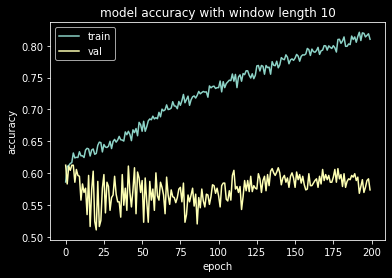

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

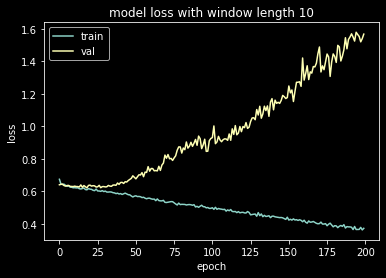

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

118/118 [==============================] - 0s 168us/step
for window length 10 we have: test loss, test acc: [4.057830139742059, 0.5932203531265259]


**Next, we train the model with window size 20 to see how the increase of window size affects the test accuracy**

In [25]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, stock_with_max_trading_per_day, training_start, training_end, testing_start, testing_end, window_in_days=20)

model = build_model(training_data.shape)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [26]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2982 samples, validate on 746 samples
Epoch 1/200
2982/2982 [==============================] - 3s 1ms/step - loss: 0.6700 - binary_accuracy: 0.5942 - val_loss: 0.6449 - val_binary_accuracy: 0.6113
Epoch 2/200
2982/2982 [==============================] - 2s 806us/step - loss: 0.6546 - binary_accuracy: 0.6033 - val_loss: 0.6370 - val_binary_accuracy: 0.6139
Epoch 3/200
2982/2982 [==============================] - 2s 818us/step - loss: 0.6424 - binary_accuracy: 0.6144 - val_loss: 0.6330 - val_binary_accuracy: 0.6113
Epoch 4/200
2982/2982 [==============================] - 2s 826us/step - loss: 0.6354 - binary_accuracy: 0.6107 - val_loss: 0.6447 - val_binary_accuracy: 0.6113
Epoch 5/200
2982/2982 [==============================] - 2s 813us/step - loss: 0.6356 - binary_accuracy: 0.6207 - val_loss: 0.6358 - val_binary_accuracy: 0.6046
Epoch 6/200
2982/2982 [==============================] - 2s 808us/step - loss: 0.6296 - binary_accuracy: 0.6174 - val_loss: 0.6312 - val_binary_accura

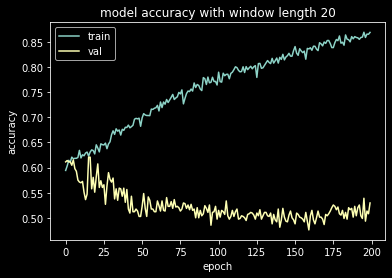

In [27]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

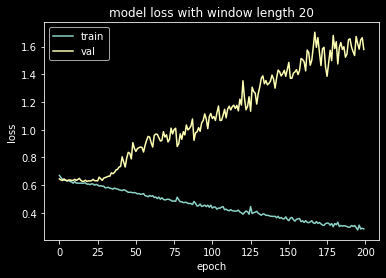

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 20 we have: test loss, test acc:', results)

108/108 [==============================] - 0s 245us/step
for window length 20 we have: test loss, test acc: [6.316175831688775, 0.6111111044883728]


**And finally, we set the window length to 30 days.**

In [36]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, stock_with_max_trading_per_day, training_start, training_end, testing_start, testing_end, window_in_days=30)

model = build_model(training_data.shape)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)                64        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                

In [38]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2974 samples, validate on 744 samples
Epoch 1/200
2974/2974 [==============================] - 4s 1ms/step - loss: 0.6762 - binary_accuracy: 0.5706 - val_loss: 0.6462 - val_binary_accuracy: 0.6008
Epoch 2/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6501 - binary_accuracy: 0.6042 - val_loss: 0.6350 - val_binary_accuracy: 0.6142
Epoch 3/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6387 - binary_accuracy: 0.6167 - val_loss: 0.6404 - val_binary_accuracy: 0.5995
Epoch 4/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6349 - binary_accuracy: 0.6076 - val_loss: 0.6448 - val_binary_accuracy: 0.5874
Epoch 5/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6258 - binary_accuracy: 0.6123 - val_loss: 0.6415 - val_binary_accuracy: 0.5860
Epoch 6/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6231 - binary_accuracy: 0.6258 - val_loss: 0.6578 - val_binary_accuracy: 0.5632

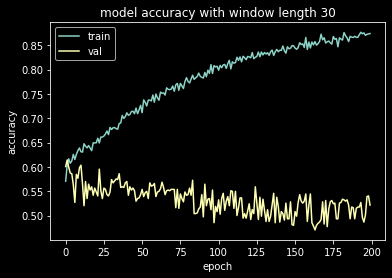

In [39]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

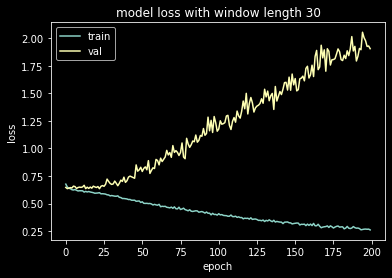

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 30 we have: test loss, test acc:', results)

98/98 [==============================] - 0s 355us/step
for window length 30 we have: test loss, test acc: [0.7026699927388406, 0.5918367505073547]
